# Preprocess the Pancreas data

This part mainly follows the procedure from the scvelo package tutorial.

In [2]:
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

In [3]:
# standard preprocessing steps from scVelo
adata2000 = scv.datasets.pancreas()
scv.pp.filter_genes(adata2000, min_shared_counts=20) 
scv.pp.normalize_per_cell(adata2000)
scv.pp.filter_genes_dispersion(adata2000, n_top_genes=2000) # only leave the top 2000 genes for this run for simplicity
scv.pp.log1p(adata2000)
scv.pp.moments(adata2000, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
#  #  stochastic model
#  #  not used for this run
# scv.tl.velocity(adata2000)
# scv.tl.velocity_graph(adata2000, n_jobs=8)

In [4]:
# Using dynamical model (see paper) to calculate gene velocity
scv.tl.recover_dynamics(adata2000, n_jobs=8)
scv.tl.velocity(adata2000, mode='dynamical')

recovering dynamics (using 8/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:07:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [5]:
# computing velocity graph
# this gives the sparse matrix with cosine correlations (adata.uns)
scv.tl.velocity_graph(adata2000, n_jobs=8)

computing velocity graph (using 1/12 cores)
    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
# to look at the AnnData object with the processed results
adata2000

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [3]:
# processed data saved, just need to read in when rerun

# adata2000.write('data/pancreasd2000.h5ad', compression='gzip')
adata2000 = scv.read('data/pancreasd2000.h5ad')

Comparing the velocity graphs calculated based on full data vs top 2000 gene data and they are pretty different

In [ ]:
# # This is processed leaving top 5000 genes
# adataTop = scv.read('data/pancreasTop5000.h5ad')
# adata = scv.read('data/pancreas.h5ad')

# import pickle
# layout_r = pickle.load(open("layout_r.pkl","rb"))[0]
# skeleton_r = pickle.load(open("skeleton_r.pkl","rb"))

# # look at the difference
# np.sum((adata2000.uns["velocity_graph"] - adata.uns["velocity_graph"]).power(2))

In [ ]:
# # visualizations following the scvelo tutorial

# scv.pl.velocity_embedding_stream(adata2000, basis='umap')

# df = adata2000.var
# df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

# kwargs = dict(xscale='log', fontsize=16)
# with scv.GridSpec(ncols=3) as pl:
#     pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
#     pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
#     pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

# scv.get_df(adata2000, 'fit*', dropna=True).head()

# scv.tl.latent_time(adata2000)
# scv.pl.scatter(adataTop, color='latent_time', color_map='gnuplot', size=80) 

# top_genes = adata2000.var['fit_likelihood'].sort_values(ascending=False).index[:300]
# scv.pl.heatmap(adataTop, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [ ]:

# velocity = adataTop.layers["velocity"]
# np.sum(np.isnan(velocity))
# hasvelo = np.logical_not( np.isnan(velocity[0]) )
# velocity = velocity[:,hasvelo]
# adataTop_v = adataTop[:,hasvelo]

# Manual compute cosine similarity

This is to verify the methodology given by the scvelo package.

In [18]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import skeleton_methods.skeleton as skel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph
from numpy.linalg import norm

import random
 
random.seed(123)

There are several things the method did to before computing the cosine similarity:

. First, for the the location feature, instead of using the total gene counts (data.X), the algorithm by default uses data.layers["Ms"], which is the dense matrix with first order moments of spliced counts.

. Second, only genes under "velocity_genes" are included for computation

. only leave none na genes for the computation

. dX is defined as Xj - Xi, and then dX is centered by subtracting the mean of the vector, which doesn't really affect the cosine computation. V is also centered

In [18]:
# specify the location features and velocity
# Need to run this for following analysis
X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]

subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]

In [ ]:
# resulting in 1027 genes involved for following analysis
X.shape

(3696, 1027)

In [ ]:
# xdiff = (X[3690]-  X[0])
# xdiff = xdiff - xdiff.mean()
# xdiff = np.sqrt(np.abs(xdiff))* np.sign(xdiff)
# V = np.sqrt(np.abs(V))* np.sign(V)

# Skeleton constructed based on Ms features

In [8]:
import skeleton_methods.skeleton as skel
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph
from collections import defaultdict
from numpy.linalg import norm

import random
 
random.seed(123)

In [2]:
# define the knot construction function
def constructKnots(X, centers = None, labels = None, k = None, rep = 100):
    """
      construct knots using overfitting kMeans
  
      Parameters
      ----------
      X : np.array
          the data ndarray
      centers: np.array of the knots, can be provided
      labels: np.array of the knot label that each data point belongs to
      k: the number of knots
      rep: times of random initialization for kMeans
  
      Returns
      -------
      centers: ndarray of the constructed knots
      cluster: array of knot labels to which the data points belong to
      nknots: number of knots
      withinss: within cluster sum of squares for each Voronoi cell corresponding to the knots
    """
    n, d = X.shape
    #construct knots
    if centers is None and labels is None:
        # Overfitting k-means
        #setting the number of knots k
        if k is None:
            k = round(np.sqrt(n))
    
        km = KMeans(n_clusters = k, n_init = rep)
        km.fit(X)
        centers = km.cluster_centers_
        labels = km.labels_
    
    elif labels is None:#centers provided but not labels
        nbrs = NearestNeighbors(n_neighbors=1).fit(centers)
        labels = nbrs.kneighbors(X, return_distance=False)
        labels = np.array([sublist[0] for sublist in labels])
        k = len(centers)
          
    elif centers is None:#labels provided but not centers
        elements_count = collections.Counter(labels)
        k = len(elements_count.items())
        centers = np.array([[0.0 for col in range(d)] for row in range(k)])
        for key, value in elements_count.items():
            centers[key,] = np.mean(X[labels == key,], axis=0)
      
    else:
        k = len(centers)
        
      
    withinss = np.array([0.0]*k)
    for i in range(k):
        withinss[i] = np.sum(np.square(X[labels == i,:]-centers[i,:]))
      
    return {"centers":centers, "cluster":labels, "nknots":k, "withinss": withinss}

In [ ]:
# construct knots, initial run
conKnots = constructKnots(X, k = 100)
skeleton = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton.update(edgeWeights)
X_nn = skeleton["nn"]
knots = skeleton["centers"]
kkdists = distance_matrix(knots,knots)

In [ ]:
# Compute the cluster sizes for refining skeleton
knotSizes = np.zeros(100)
for i in range(100):
    knotSizes[i]= sum(X_nn[:,0] == i)
sum(knotSizes<5)

0

In [ ]:
#filter out small clusters and reconstruct
knots = np.array(knots[knotSizes>=5,:])
conKnots = constructKnots(X, centers= knots)
skeleton = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton.update(edgeWeights)

In [ ]:
# recompute cluster sizes
X_nn = skeleton["nn"]
knots = skeleton["centers"]
kkdists = distance_matrix(knots,knots)
knotSizes = np.zeros(len(knots))
for i in range(len(knots)):
    knotSizes[i]= sum(X_nn[:,0] == i)

In [ ]:
# compute the voronoi similarity between knots, which is counting the data points with the pair of knots as the two closest knots.
# These weights can be used for approximate Delaunnay triangulation
def VoronSimilarity(knots, X_nn, kkdists):
    m = knots.shape[0]
    voron_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
    for i in range(m-1): #loop through knots pairs
        # center1 = knots[i]
        wi1 = np.where(X_nn[:,0] == i)[0]
        wi2 = np.where(X_nn[:,1] == i)[0]
        for j in range(i+1,m):
            # center2 = knots[j]
            wj1 = np.where(X_nn[:,0] == j)[0]
            wj2 = np.where(X_nn[:,1] == j)[0]
            #data point indices within 2nn neighborhood of knots i, j
            nn2ij = np.union1d(np.intersect1d(wi1, wj2), np.intersect1d(wi2, wj1))
        
            if len(nn2ij) < 1 :#not in Delaunnay Triangulation
                voron_weights[i,j] = 0.0
                continue
        
            # Euclidean distance between two centers
            d12 = kkdists[i,j]

            #compute the Voronoi density 
            voron_weights[i,j] = len(nn2ij)/d12
    return voron_weights

voron_weights = VoronSimilarity(knots, X_nn, kkdists)
skeleton.update( {"voron_weights": voron_weights + np.transpose((voron_weights))})

In [9]:
# To get major cell types within each voronoi cell
X_nn = skeleton["nn"]
knots = skeleton["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

In [13]:
# print to examine cell types within each region
# find clusters that need refine
# knots to further split and refine. Picked the cells where the second major cell type 
# has counts more than half of the most common cell type and larger than 10 in counts.

refineId = []
for i in range(len(knots)):
    # print(i)
    # print(knotClusbyCell[i])
    if max(knotClusbyCell[i].values)< 0.67*sum(knotClusbyCell[i].values) and 0.33*sum(knotClusbyCell[i].values)>10:
        refineId.append(i)

# refineId = [17,24,35,38,55,78,81,88,99]    

In [ ]:
# refine id
for id in refineId:
    knots[id,:] = np.mean( X[np.logical_and( X_nn[:,0] == id , adata2000.obs['clusters'] == knotClusbyCell[id].index[0]),:], axis= 0)
    knots = np.vstack((knots, 
                       np.mean( X[np.logical_and( X_nn[:,0] == id , adata2000.obs['clusters'] != knotClusbyCell[id].index[0]),:], axis= 0)))

In [ ]:
# recalculate skeleton quantities based on refined knots
conKnots = constructKnots(X, centers= np.array(knots))
skeleton_r = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton_r.update(edgeWeights)

In [ ]:
# examine the refined skeleton
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]
kkdists = distance_matrix(knots,knots)
knotSizes = np.zeros(len(knots))
for i in range(len(knots)):
    knotSizes[i]= sum(X_nn[:,0] == i)
min(knotSizes)

8.0

In [ ]:
# calculate the voronoi weights with refined knots
voron_weights_r = VoronSimilarity(knots, X_nn, kkdists)
skeleton_r.update( {"voron_weights": voron_weights_r + np.transpose((voron_weights_r))})

In [ ]:
# Use closest observation X for each knot for UMAP plotting. Save time for UMAP calculation
nbrs = NearestNeighbors(n_neighbors=1).fit(X)
nnx = nbrs.kneighbors(skeleton_r["centers"], return_distance=False) 

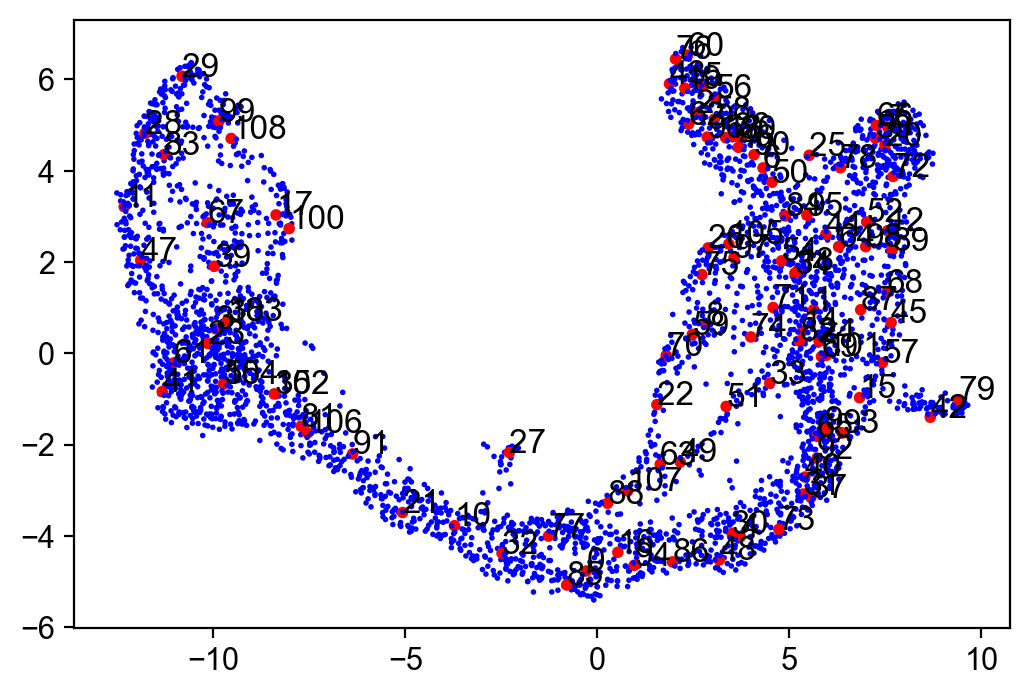

In [ ]:
# make knots larger sizes for plotting
sizes = np.array([1]*X.shape[0])
sizes[nnx[:,0]] = 10
colors = ['red' if i in nnx[:,0] else 'blue' for i in range(X.shape[0])]
fig, ax = plt.subplots()
ax.scatter(adata2000.obsm["X_umap"][:,0],adata2000.obsm["X_umap"][:,1], s=sizes ,c=colors)
for i in range(len(knots)):
    ax.annotate(str(i), (adata2000.obsm["X_umap"][:,0][nnx[i,0]], adata2000.obsm["X_umap"][:,1][nnx[i,0]]))
plt.show()

In [ ]:
# create a graph layout same as the above UMAP positions
coords = [ [adata2000.obsm["X_umap"][:,0][nnx[i,0]], adata2000.obsm["X_umap"][:,1][nnx[i,0]]] for i in range(len(knots)) ]
layout_r = igraph.Layout(coords)

In [ ]:
# Segment Skeleton
# leaving the graph as a whole in this case, but just run this for constructing the graph objects for the skeleton
import skeleton_methods.clustering as skelclus
knots = skeleton_r["centers"]
X_knotlabels = skeleton_r["cluster"]

#similarities
weights = skeleton_r["voron_weights"]
kcut = 1
hclustKnot = skelclus.cluster_weights(weights, X_knotlabels, kcut = kcut, method='average')

tol = 1e-10
#choose correct cut
cutheight = hclustKnot["hclust"][-kcut][2]
#cut some edges
weights[weights<(np.max(weights)-cutheight+tol)] = 0

#Euclidean distance between centers
# can be updated if doing cuts and distances between unconnected components are set to 0
kkdists = distance_matrix(knots,knots)
kkdists[weights == 0] = 0

skeleton_r.update({"kkdists": kkdists, "cutWeights": weights, "g" :g}) 



In [ ]:
import pickle
# save the computed skeleton
pickle.dump(skeleton_r, open("Msskeleton_r.pkl", "wb"))
# save the layout
pickle.dump(layout_r, open("Mslayout_r.pkl", "wb"))

In [4]:
# Just need to load with new code running process
import pickle
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
skeleton_r.keys()

dict_keys(['centers', 'cluster', 'nknots', 'withinss', 'nn', 'voron_weights', 'kkdists', 'cutWeights', 'g'])

<Axes: >

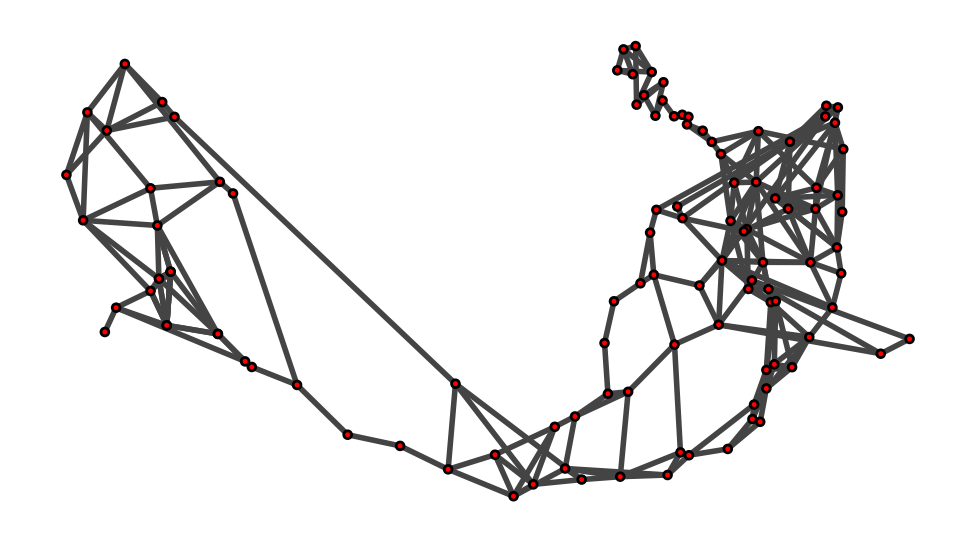

In [ ]:
# plotting the skeleton graph using the same layout us UMAP

# import random
# random.seed(1234)
g = igraph.Graph.Weighted_Adjacency(skeleton_r["kkdists"].tolist(),  mode='undirected')
fig, ax = plt.subplots()
# layout_r = g.layout("kk")
igraph.plot(g, layout=layout_r, target=ax)

<Axes: >

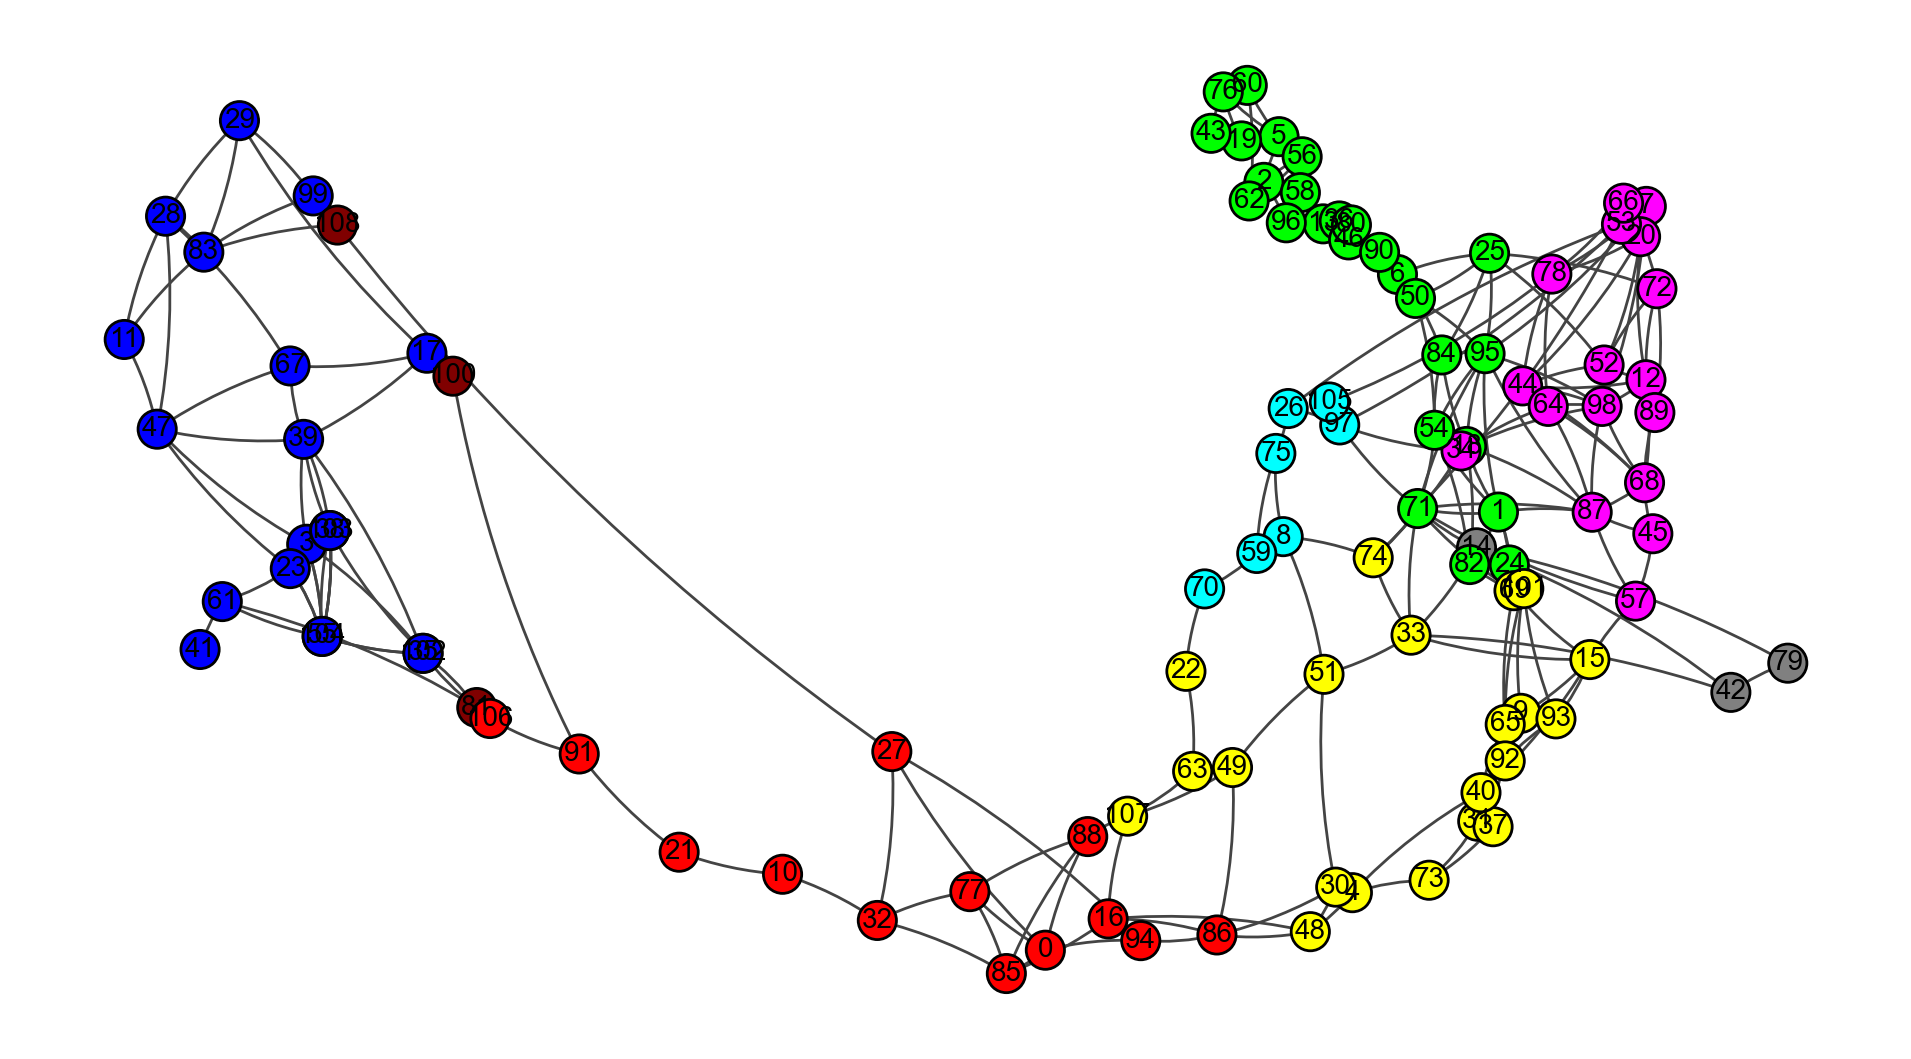

In [ ]:
# color the knots with the major cell type in each
from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]
id_gen = igraph.UniqueIdGenerator()
color_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
colors = [palette[index] for index in color_indices]
g.vs["color"] = colors 

g.vs["label"] = [i for i in range(len(knots))]


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(g, layout=layout_r, target=ax, autocurve = True,edge_curved="0.1", edge_width = 1,vertex_size = 0.5, vertex_label_size = 10)

color index,  color,  type

0             red        'Ngn3 high EP'

1             green      'Beta'

2             dark blue  'Ductal'

3             yellow     'Pre-endocrine'

4             purple     'Alpha'

5             cyan        'Epsilon'

6             gray        'Delta'

7             brown       'Ngn3 low EP'



In [ ]:
[id_gen.add(value) for value in np.unique(majorCellClus)] 

[4, 1, 6, 2, 5, 0, 7, 3]

In [ ]:
np.unique(majorCellClus)

array(['Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Ngn3 high EP',
       'Ngn3 low EP', 'Pre-endocrine'], dtype='<U13')

In [ ]:
for value in range(8):
    print([i for i in range(len(color_indices)) if color_indices[i] == value])

[0, 10, 16, 21, 27, 32, 77, 85, 86, 88, 91, 94, 106]
[1, 2, 5, 6, 13, 18, 19, 24, 25, 36, 43, 46, 50, 54, 56, 58, 60, 62, 71, 76, 80, 82, 84, 90, 95, 96]
[3, 11, 17, 23, 28, 29, 38, 39, 41, 47, 55, 61, 67, 83, 99, 102, 103, 104]
[4, 9, 15, 22, 30, 31, 33, 37, 40, 48, 49, 51, 63, 65, 69, 73, 74, 92, 93, 101, 107]
[7, 12, 20, 34, 44, 45, 52, 53, 57, 64, 66, 68, 72, 78, 87, 89, 98]
[8, 26, 59, 70, 75, 97, 105]
[14, 42, 79]
[35, 81, 100, 108]


# Aggregate cell-level velocity graph to get knot level similarity graph

In [77]:
# read in saved quantities if not already in workspace
import pickle
adata2000 = scv.read('data/pancreasd2000.h5ad')
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
# specify the location features and velocity

X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]
subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]


In [79]:
# normalize velocities to be unit length
row_sums = norm(V,axis=1)
V = V / row_sums[:, np.newaxis]

In [8]:
# take the mean of cell-level cosine similarities for knot-level similarities
velocity_graph = adata2000.uns["velocity_graph"]
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]
voron_weights = skeleton_r["voron_weights"]


In [7]:
def KnotSimilarity_meanOfCosines(data, skeleton):
    """
      take the mean of cell-level cosine similarities for knot-level similarities
  
      Parameters
      ----------
      data : adata
          the adata object given by scvelo

      skeleton: the constructed skeleton object
  
      Returns
      -------
      A list with the following objects:
            
      idxSet: dictionary with knot index to be the key, corresponding to array indicating 
                whether the observation belongs to the neighborhood of the knot 
      knot_velocity_graph: 2D array showing similarity between knots as given by 
                the mean of cell-level cosine similarities within the two neighborhoods
    """
    X_nn = skeleton["nn"]
    knots = skeleton["centers"]
    voron_weights = skeleton["voron_weights"]
    velocity_graph = data.uns["velocity_graph"]
    
    # for each knot find the index set of observations in its neighborhood
    idxSet = defaultdict(lambda: "Not Present")
    for i in range(len(knots)):
        idxSet[i] = skeleton["cluster"] == i
        
    knot_velocity_graph = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
    for i in range(len(knots)):
        for j in range(len(knots)):
            mat = velocity_graph[idxSet[i]][:, idxSet[j]]
            if mat.count_nonzero() == 0:
                knot_velocity_graph[i,j] = 0
            else:
                knot_velocity_graph[i,j] = mat.sum() / mat.count_nonzero()
                
    # remove some edges according to the constructed skeleton
    knot_velocity_graph[voron_weights==0]=0
    
    return [idxSet,  knot_velocity_graph]
    

In [11]:
idxSet, knot_velocity_graph = KnotSimilarity_meanOfCosines(adata2000, skeleton_r)

In [87]:
def Prune_knot_graph(knot_velocity_graph, quantile = 0.5):
    """
      Prune some entries in knot similarity graph
  
      Parameters
      ----------
      knot_velocity_graph : matrix of pairwise similarity between knots

      thres: the quantile of the entries in the matrix used as pruning threshold
  
      Returns
      -------
      knot_velocity_graph1: pruned matrix of similarities between knots
    """
    nknots = len(knot_velocity_graph)
    # prune the knot similarity by the medium value in the matrix
    thres = np.quantile(knot_velocity_graph[knot_velocity_graph > 0], quantile)
    knot_velocity_graph1 = np.array([[0.0 for _ in  range(nknots)] for _ in range(nknots)])
    for i in range(nknots):
        for j in range(i+1,nknots):
            if knot_velocity_graph[i,j] < knot_velocity_graph[j,i]:
                knot_velocity_graph1[j,i] = knot_velocity_graph[j,i]
                if knot_velocity_graph[i,j] > thres:
                    knot_velocity_graph1[i,j] = knot_velocity_graph[i,j]
            else:
                knot_velocity_graph1[i,j] = knot_velocity_graph[i,j]
                if knot_velocity_graph[j,i] > thres:
                    knot_velocity_graph1[j,i] = knot_velocity_graph[j,i]
    return knot_velocity_graph1

knot_velocity_graph1 = Prune_knot_graph(knot_velocity_graph)


In [13]:
def Decorate_knot_graph(knot_velocity_graph, data, skeleton):
    X_nn = skeleton["nn"]
    knots = skeleton["centers"]
    
    # construct the igraph object for graph
    velog_1e = igraph.Graph.Weighted_Adjacency(knot_velocity_graph.tolist(),  mode='directed') 

    # for each knot, get the distribution of cell types within its Voronoi cell
    knotClusbyCell = defaultdict(lambda: "Not Present")
    for i in range(len(knots)):
        df = pd.Series(data.obs['clusters'][X_nn[:,0] == i])
        knotClusbyCell[i] = df.value_counts()
    # get the major cell type for each knot
    majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

    # assign color to knot by major cell type
    id_gen = igraph.UniqueIdGenerator()
    vcolor_indices = [id_gen.add(value) for value in majorCellClus]
    palette = igraph.ClusterColoringPalette(len(id_gen))
    vcolors = [palette[index] for index in vcolor_indices]
    velog_1e.vs["color"] = vcolors 

    # label each knot by index
    velog_1e.vs["label"] = [i for i in range(len(knots))]

    # color each edge by the weight category. Here in 3 categories
    # edge weights are the aggregated cosine similarities between knots
    edgeWeightCat = (np.round(np.array(velog_1e.es["weight"])*3)).astype(int)
    palette = igraph.ClusterColoringPalette(len(edgeWeightCat))
    edgecolors = [palette[index] for index in edgeWeightCat]
    velog_1e.es["color"] = edgecolors 

    # width of each edge shows weights
    velog_1e.es['width'] = np.sqrt(edgeWeightCat)*2 + 1
    
    return velog_1e

In [16]:
velog_1e = Decorate_knot_graph(knot_velocity_graph1, adata2000, skeleton_r)

In [19]:
# specify graph plotting layout using kk algorithm
# the UMAP based layout is not working, so a kk algorithm based layout here


# layout0 = velog_1e.layout("kk")
# layout0.rotate(90)
# layout0.mirror(1)
import pickle
# pickle.dump(layout0, open("Mslayout0.pkl", "wb"))
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

<Axes: >

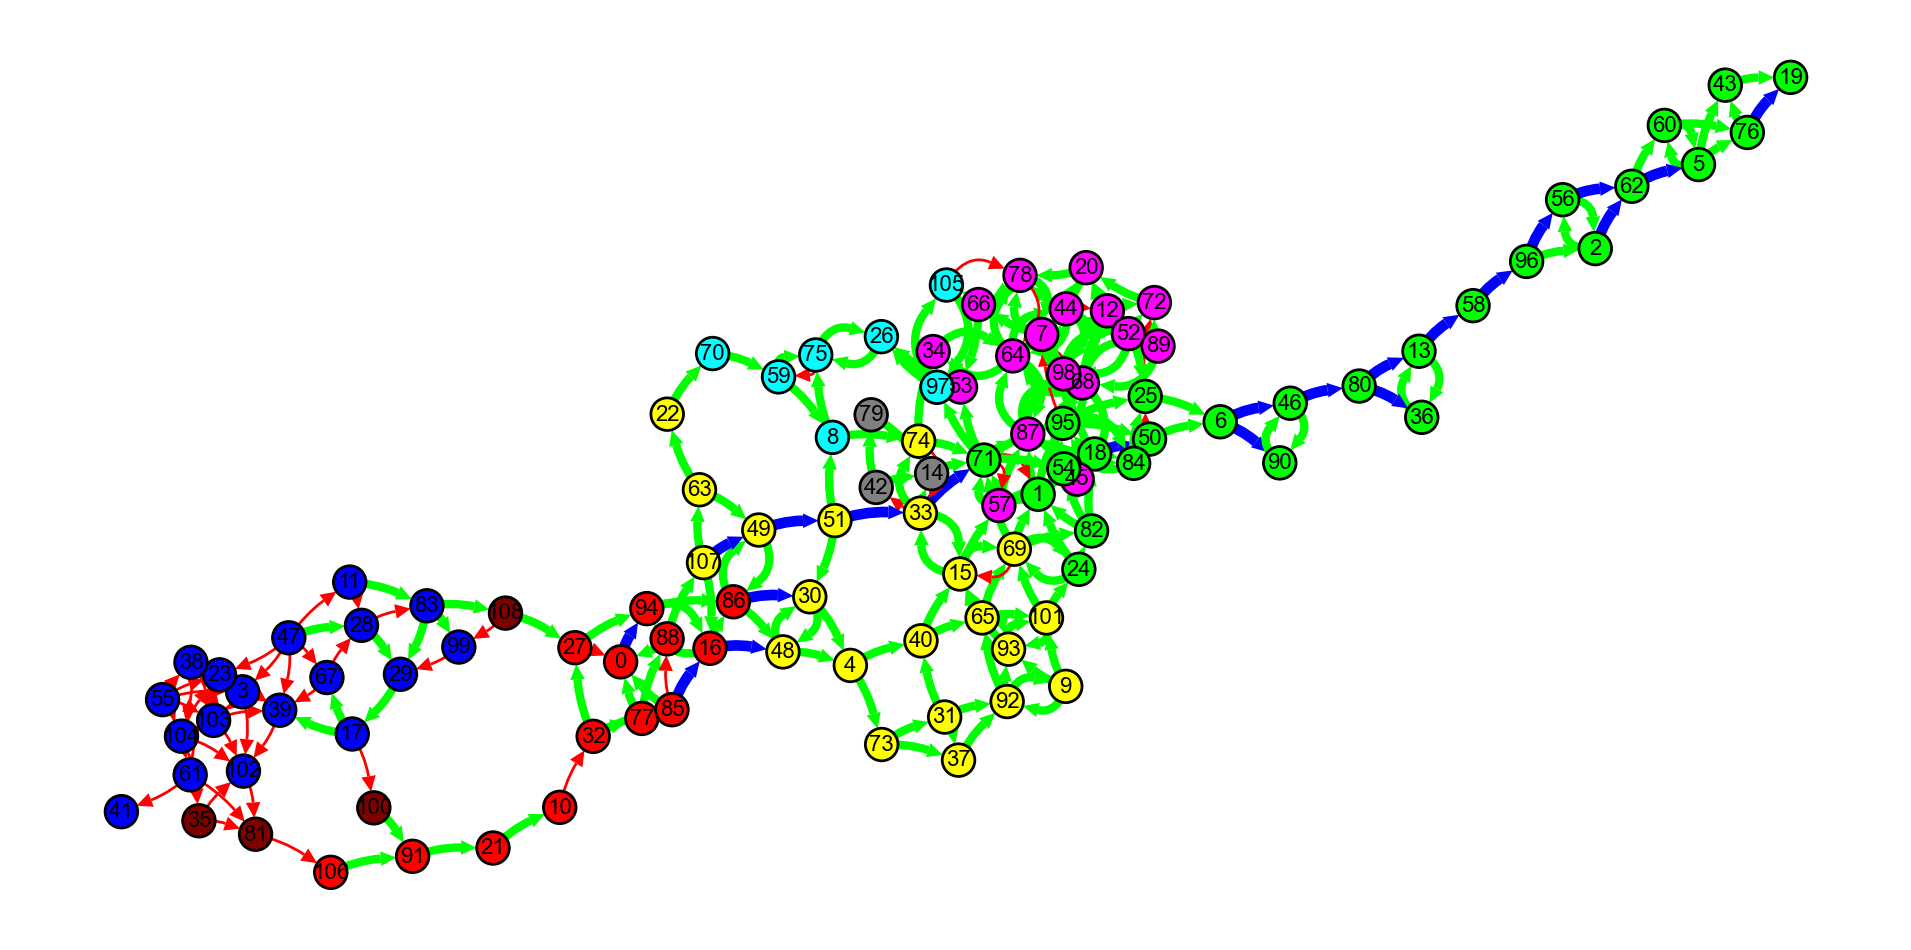

In [20]:
# plot the knot graph
fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_1e, layout=layout0, target=ax, autocurve = True,edge_curved="0.1", vertex_size = 0.2, vertex_label_size = 8)

# Average the cell velocities within neighborhood as knot velocity and then calculate knot-level cosine similarity

In [84]:
def KnotSimilarity_CosineOfMeanVelocity(skeleton, velocity):
    """
      calculate the velocity of the knot as the geometric mean vector of the velocities in the neighborhood, 
      which maximizes the cosine similarity between the mean vector and all the velocity vectors.
      (Note that bisecting two vectors on the unit sphere is the same as finding the Euclidean mean of the two vectors 
      and then extend to the unit sphere, therefore the iterative bisecting algorithm gives the same result as maximize cosine similarities.)
      (Note this can be different from the Frechet mean)
  
      Parameters
      ----------
      data : adata
          the adata object given by scvelo

      skeleton: the constructed skeleton object
  
      Returns
      -------
      A list with the following objects:
      
      idxSet: dictionary with knot index to be the key, corresponding to array indicating 
                whether the observation belongs to the neighborhood of the knot.

      knot_velocity: the velocity vector at each knote
      
      knot_velocity_graph: 2D array showing similarity between knots as given by 
                the cosine similarity between two kont velociteis.
    """
    knots = skeleton["centers"]
    voron_weights = skeleton["voron_weights"]
    
    # Compute knot velocity

    # nans = np.isnan(np.sum(velocity, axis=0))
    # if np.any(nans):
    #     X = X[:, ~nans]
    #     velocity = velocity[:, ~nans]

    # for each knot find the index set of observations in its neighborhood
    idxSet = defaultdict(lambda: "Not Present")
    for i in range(len(knots)):
        idxSet[i] = skeleton["cluster"] == i

    # calculate the velocity on each knot
    knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
    for i in range(len(knots)):
        knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)
        
    # normalize to be unit length bector
    row_norms = norm(knot_velocity,axis=1)
    knot_velocity = knot_velocity/row_norms[:, np.newaxis] 

    # # find the location of each knot
    # knot_X = np.array([[0.0 for _ in  range(X.shape[1])] for _ in range(len(knots))])
    # for i in range(len(knots)):
    #     knot_X[i,:] = np.mean(X[idxSet[i],:], axis = 0)
        
    # use knot velocity to get cosine similarity graph between knots
    knot_velocity_graph_direct0 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
    for i in range(len(knots)):
        for j in range(len(knots)):
            if i != j and voron_weights[i,j] > 0:
                xdiff = knots[j,:]-  knots[i,:]
                knot_velocity_graph_direct0[i,j] = np.dot(knot_velocity[i,:], xdiff)/(norm(xdiff)*norm(knot_velocity[i,:]))
                
    return [idxSet, knot_velocity, knot_velocity_graph_direct0]
    

In [85]:
idxSet, knot_velocity, knot_velocity_graph_direct0 = KnotSimilarity_CosineOfMeanVelocity(skeleton_r, V)

In [89]:
# prune the graph same as previous approach
knot_velocity_graph1 = Prune_knot_graph(knot_velocity_graph_direct0, quantile=0.3)

In [ ]:
# # For prunning edges
# thres = np.quantile(knot_velocity_graph_direct0[knot_velocity_graph_direct0 > 0], 0.3)

# knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
# for i in range(len(knots)):
#     for j in range(i+1,len(knots)):
#         if knot_velocity_graph_direct0[i,j] < knot_velocity_graph_direct0[j,i]:
#             knot_velocity_graph1[j,i] = knot_velocity_graph_direct0[j,i]
#             if knot_velocity_graph_direct0[i,j] > thres:
#                 knot_velocity_graph1[i,j] = knot_velocity_graph_direct0[i,j]
#         else:
#             knot_velocity_graph1[i,j] = knot_velocity_graph_direct0[i,j]
#             if knot_velocity_graph_direct0[j,i] > thres:
#                 knot_velocity_graph1[j,i] = knot_velocity_graph_direct0[j,i]

In [91]:
def Decorate_knot_graph2(knot_velocity_graph, data, skeleton):
    # This graph decoration uses some different parameters compared to the previous approach
    # can be improved with more parameters, but feeling would be easier to manually tune visualizations for now
    
    # construct the igraph object for graph
    velog_r = igraph.Graph.Weighted_Adjacency(knot_velocity_graph.tolist(),  mode='directed') 

    X_nn = skeleton["nn"]
    knots = skeleton["centers"]

    # for each knot, get the distribution of cell types within its Voronoi cell
    knotClusbyCell = defaultdict(lambda: "Not Present")
    for i in range(len(knots)):
        df = pd.Series(data.obs['clusters'][X_nn[:,0] == i])
        knotClusbyCell[i] = df.value_counts()
    # major cell type
    majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

    # decorate vertex colors as major cell types
    id_gen = igraph.UniqueIdGenerator()
    vcolor_indices = [id_gen.add(value) for value in majorCellClus]
    palette = igraph.ClusterColoringPalette(len(id_gen))
    vcolors = [palette[index] for index in vcolor_indices]
    velog_r.vs["color"] = vcolors 

    velog_r.vs["label"] = [i for i in range(len(knots))]

    # bins = np.quantile(np.array(velog_r.es["weight"]), [0,0.33, 0.67,1])
    # bins[0] = bins[0] -1
    # bins[-1] = bins[-1] +1
    # edgeWeightCat = pd.cut(pd.Series(velog_r.es["weight"]), bins)
    # edgeWeightCatcode = edgeWeightCat.cat.codes


    # decorate edges with weights, showing as differnt colors and width
    edgeWeightCatcode =(np.round(np.array(velog_1e.es["weight"])*3)).astype(int)

    palette = list(igraph.ClusterColoringPalette(len(np.unique(edgeWeightCatcode))))
    # palette[3] = (0.0, 0.0, 0.0, 1.0)
    edgecolors = [palette[index] for index in edgeWeightCatcode]
    velog_r.es["color"] = edgecolors 

    velog_r.es['width'] = edgeWeightCatcode*1.5 + 1
    
    return velog_r




<Axes: >

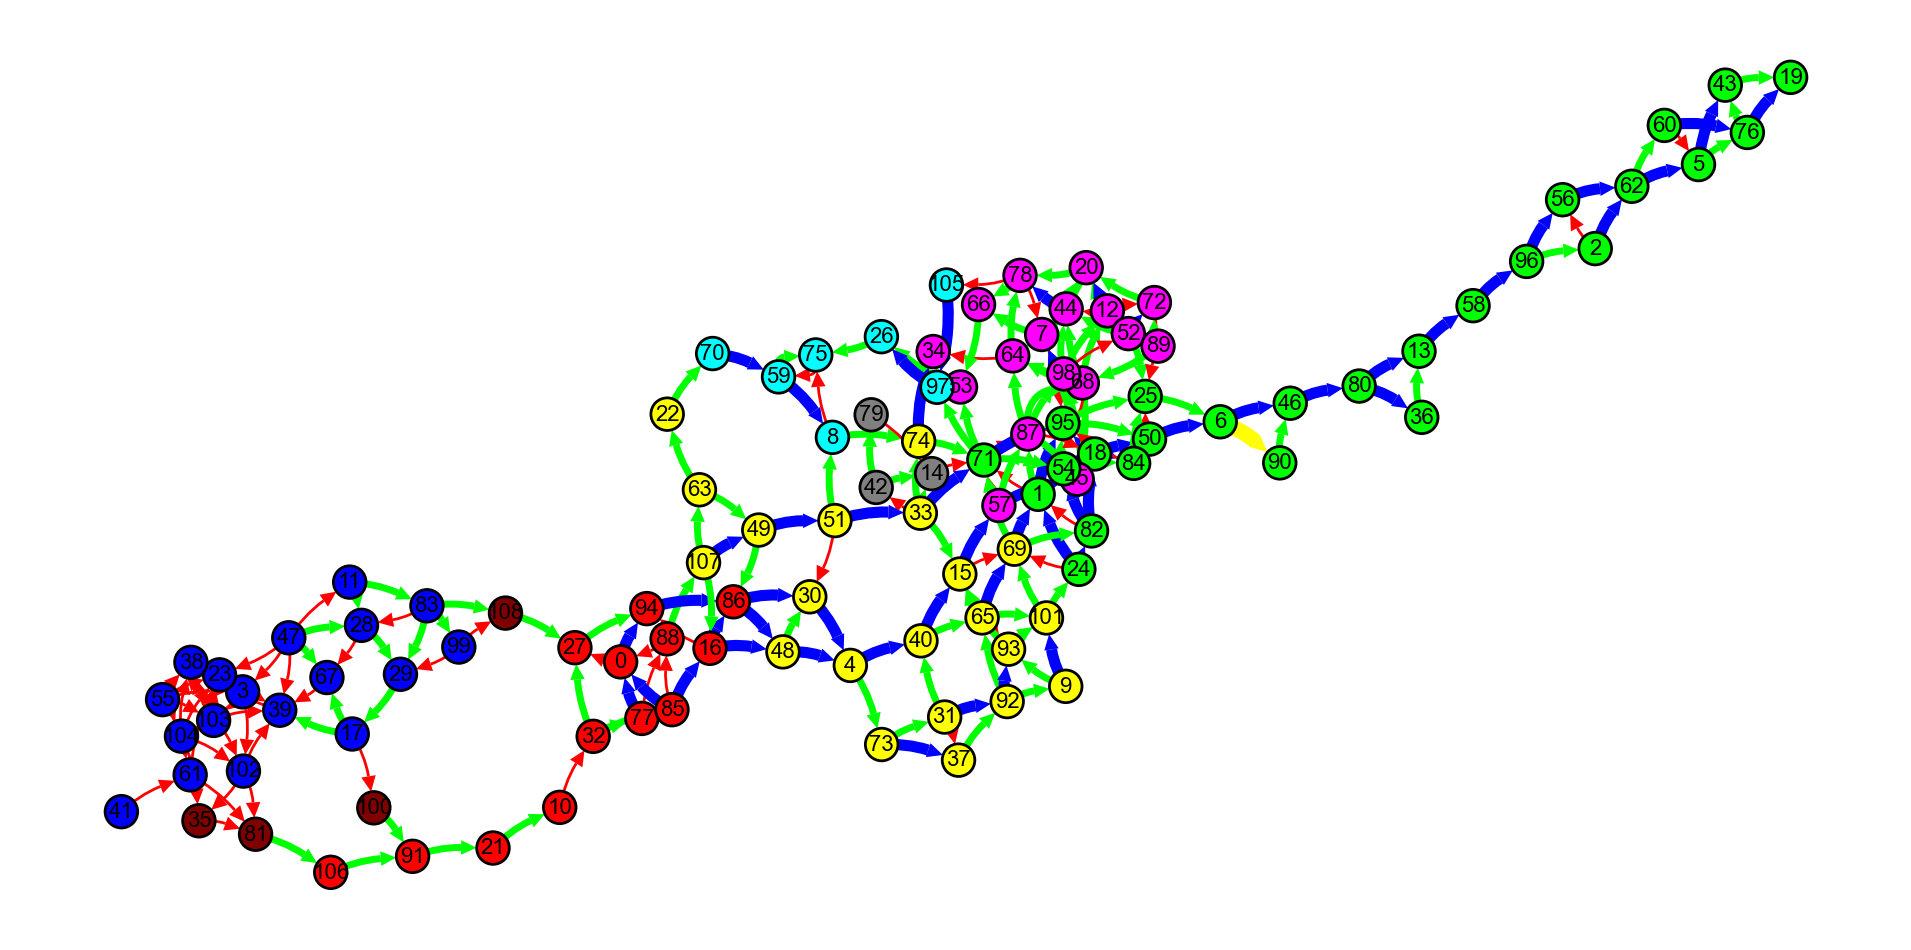

In [93]:
import pickle
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

# construct the decorated igraph object for plotting
velog_r = Decorate_knot_graph2(knot_velocity_graph1, adata2000, skeleton_r)

fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_r, layout=layout0, target=ax, autocurve = True,edge_curved="0.1",vertex_size = 0.2, vertex_label_size = 8)

# Comparison with using the cell-level velocity_graph results

This section is for exploration, comparing the two previous approach on contructing similarities between knots.

The two approaches does lead to pretty different results.

In [ ]:
knot_velocity_graph.shape
knot_velocity_graph_direct0.shape
np.sum((knot_velocity_graph - knot_velocity_graph_direct0)**2) 

45.71975784965817

In [ ]:
knot_velocity_graph_direct0[23]

array([ 0.        ,  0.        ,  0.        , -0.18344018,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.12049461,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.14294522,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.18119334,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.13616818,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
knot_velocity_graph[23]

array([0.        , 0.        , 0.        , 0.06292675, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05645442, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05571425, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05789798, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10181004, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

# Velocity Coherence within each neighborhood

We follow the second approach, analyzing the cohenerence between the velocity on the knot and the velocities in the neighborhood.

In [95]:
# cosine between cell velocities and knot velocity
# picking knot 23 as the neighborhood for illustration
knotid = 23

veloCoherence = np.sort(scv.tl.utils.cosine_correlation(V[idxSet[knotid],:], knot_velocity[knotid,:]))
veloCoherence

array([[0.72075651, 0.73275413, 0.73424963, 0.7424936 , 0.75388044,
        0.77073381, 0.77963125, 0.78430701, 0.7909618 , 0.79607872,
        0.79953667, 0.80466113, 0.81550727, 0.81573918, 0.8185843 ,
        0.81870453, 0.81894051, 0.82173065, 0.82362935, 0.82633649,
        0.82748409, 0.82998133, 0.83002202, 0.8303629 , 0.83044821,
        0.83113809, 0.83289248, 0.83407743, 0.83473168, 0.83616673,
        0.84001052, 0.84044285, 0.84121386, 0.84388878, 0.8444643 ,
        0.84619284, 0.85343946, 0.85424474, 0.85705035, 0.85751887,
        0.85850065, 0.85984521, 0.86583171, 0.86973782, 0.87095613,
        0.871943  , 0.87206293, 0.87251302, 0.87300168, 0.87480991,
        0.87650531, 0.87688678, 0.87902816, 0.88053654, 0.88237156,
        0.8867938 , 0.88752773, 0.88995305, 0.89207115, 0.89265918,
        0.892855  , 0.89488178, 0.89536414, 0.89621031, 0.89696379,
        0.89740697, 0.89847069, 0.89862269, 0.89965904, 0.9014475 ,
        0.90758141, 0.90797892, 0.90876703, 0.90

In [97]:
np.quantile(veloCoherence, [0,0.25,0.5,0.75,1])


array([0.72075651, 0.83010724, 0.87144957, 0.89858469, 0.9385904 ])

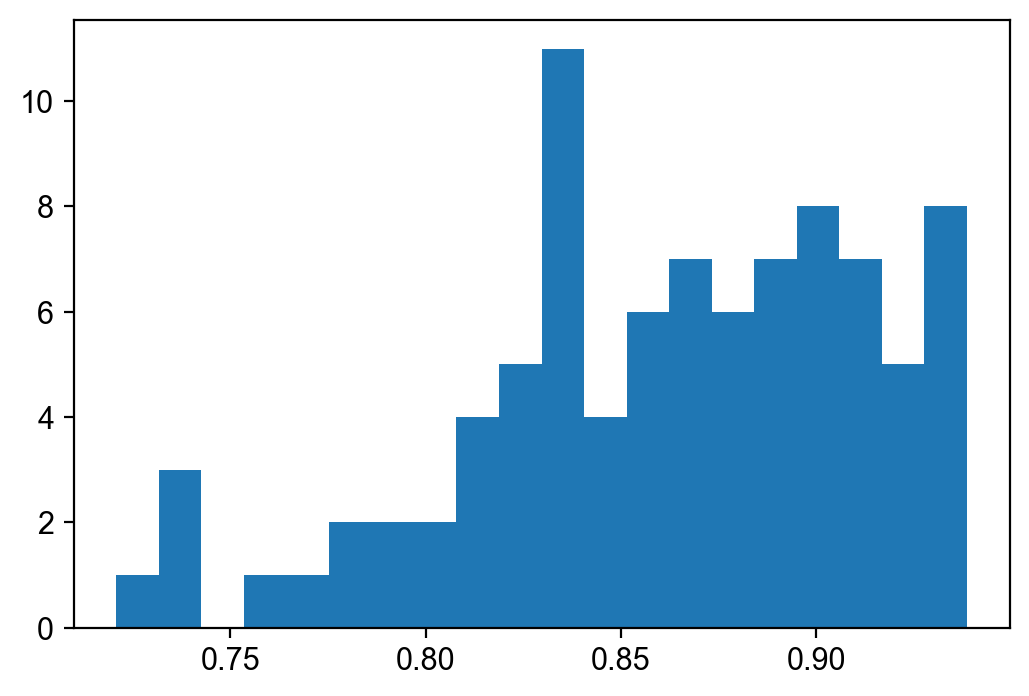

In [109]:
plt.hist(veloCoherence[0], bins=20)
plt.show()

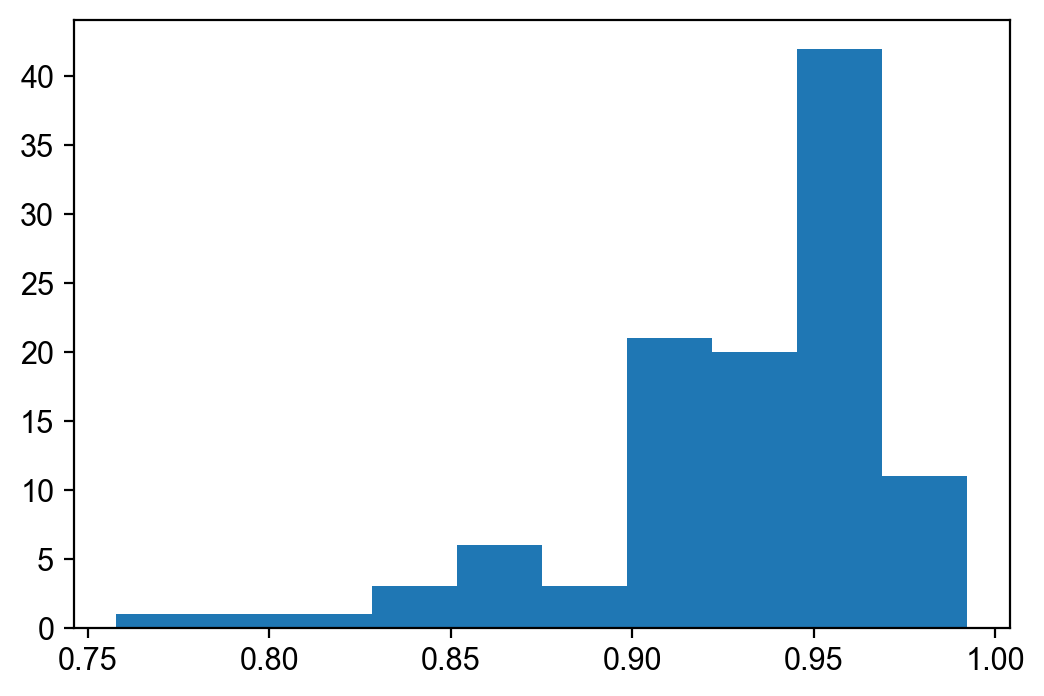

In [113]:
# say use the medium cosine value a knot velocity with the other velocities in its neighborhood as the coherence score of that neighborhood.
# iterate over the knots we would have a plot like this
allKnotCoherence = [0]*len(idxSet)
for knotid in range(len(idxSet)):
    tmp = np.sort(scv.tl.utils.cosine_correlation(V[idxSet[knotid],:], knot_velocity[knotid,:]))
    allKnotCoherence[knotid] = np.quantile(tmp, 0.5)

plt.hist(allKnotCoherence)
plt.show()

Following work would be to build on how to give an overall characterization of the within-neighborhood coherence. 

# Exploring the original cell-level velocity graph given by the scVelo package

In [100]:
# the original velocity_graph subportion
velocity_graph = adata2000.uns["velocity_graph"]
subVeloGraph = velocity_graph[idxSet[23]][:, idxSet[3]].toarray()
subVeloGraph[subVeloGraph>0].shape

(935,)

In [101]:
subVeloGraph[subVeloGraph>0].mean()

0.062926754

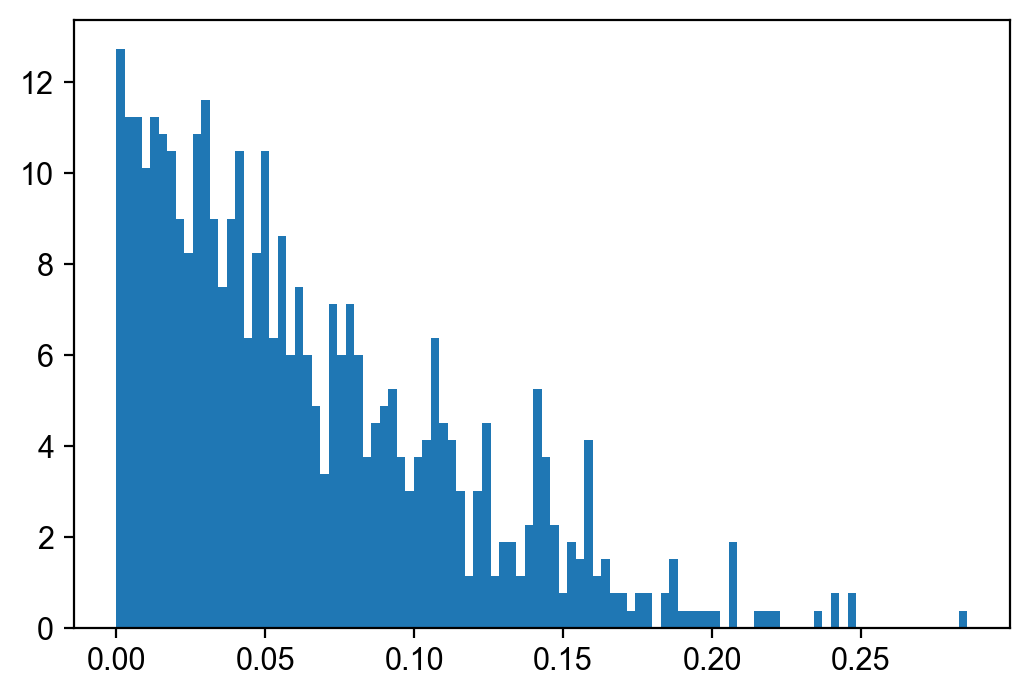

In [102]:
# import seaborn as sns
# # Make default density plot
# sns.kdeplot(subVeloGraph[subVeloGraph>0])

import matplotlib.pyplot as plt

density = np.histogram(subVeloGraph[subVeloGraph>0], density=True)

plt.hist(subVeloGraph[subVeloGraph>0], bins=100, density=True)
plt.show()

From this, we note that the cosine similarity between the cells in the two neighborhoods are weak overall but are all non-negative. But this negativeness is by the scVelo procedure that separates the negative cosine similarities into a separate matrix call "velocity_graph_neg". 

In [ ]:
np.max(adata2000.uns["velocity_graph_neg"])

0.0

In [103]:
subVeloGraph_neg = adata2000.uns["velocity_graph_neg"][idxSet[23]][:, idxSet[3]].toarray()
subVeloGraph_neg[subVeloGraph_neg<0].shape

(3735,)

In [104]:
np.concatenate((subVeloGraph_neg[subVeloGraph_neg<0], subVeloGraph[subVeloGraph>0]))

array([-0.05070815, -0.01694595, -0.0873156 , ...,  0.065231  ,
        0.00806949,  0.02170233], dtype=float32)

In [105]:
subVeloGraph_neg[subVeloGraph_neg<0].mean()

-0.1363868

There are not that many negative entreis, and combining the negative and positive cell-wise cosine similarities together doesn't change the mean much. But the cosine similarity based on the knot velocity is negative with some strength.

Feel the way existing literature generates plots by embedding the velocity first or use the velocity_graph (with only positive entries) do implicitly carry out some smoothing of the velocity and hence arrives at good visualizations.

# Use projection (with length information) instead of cosine for similarity

In [ ]:
# layout_r = pickle.load(open("layout_r.pkl","rb"))[0]
# skeleton_r = pickle.load(open("skeleton_r.pkl","rb"))


# knots = skeleton_r["centers"]
# voron_weights = skeleton_r["voron_weights"]

# from collections import defaultdict
# idxSet = defaultdict(lambda: "Not Present")
# for i in range(len(knots)):
#     idxSet[i] = skeleton_r["cluster"] == i

# knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
# for i in range(len(knots)):
#     knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)

from numpy.linalg import norm
knot_velocity_graph_direct = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if i != j and voron_weights[i,j] > 0:
            xdiff = knot_X[j,:]-  knot_X[i,:]
            knot_velocity_graph_direct[i,j] = np.dot(knot_velocity[i,:], xdiff)/norm(xdiff)


In [ ]:
# # to reverse the arrows for negative directions
# knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
# for i in range(len(knots)):
#     for j in range(len(knots)):
#         if knot_velocity_graph[i,j] > 0:
#              knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
thres = np.quantile(knot_velocity_graph_direct[knot_velocity_graph_direct > 0], 0.3)

knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(i+1,len(knots)):
        if knot_velocity_graph_direct[i,j] < knot_velocity_graph_direct[j,i]:
            knot_velocity_graph1[j,i] = knot_velocity_graph_direct[j,i]
            if knot_velocity_graph_direct[i,j] > thres:
                knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
        else:
            knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
            if knot_velocity_graph_direct[j,i] > thres:
                knot_velocity_graph1[j,i] = knot_velocity_graph_direct[j,i]

<Axes: >

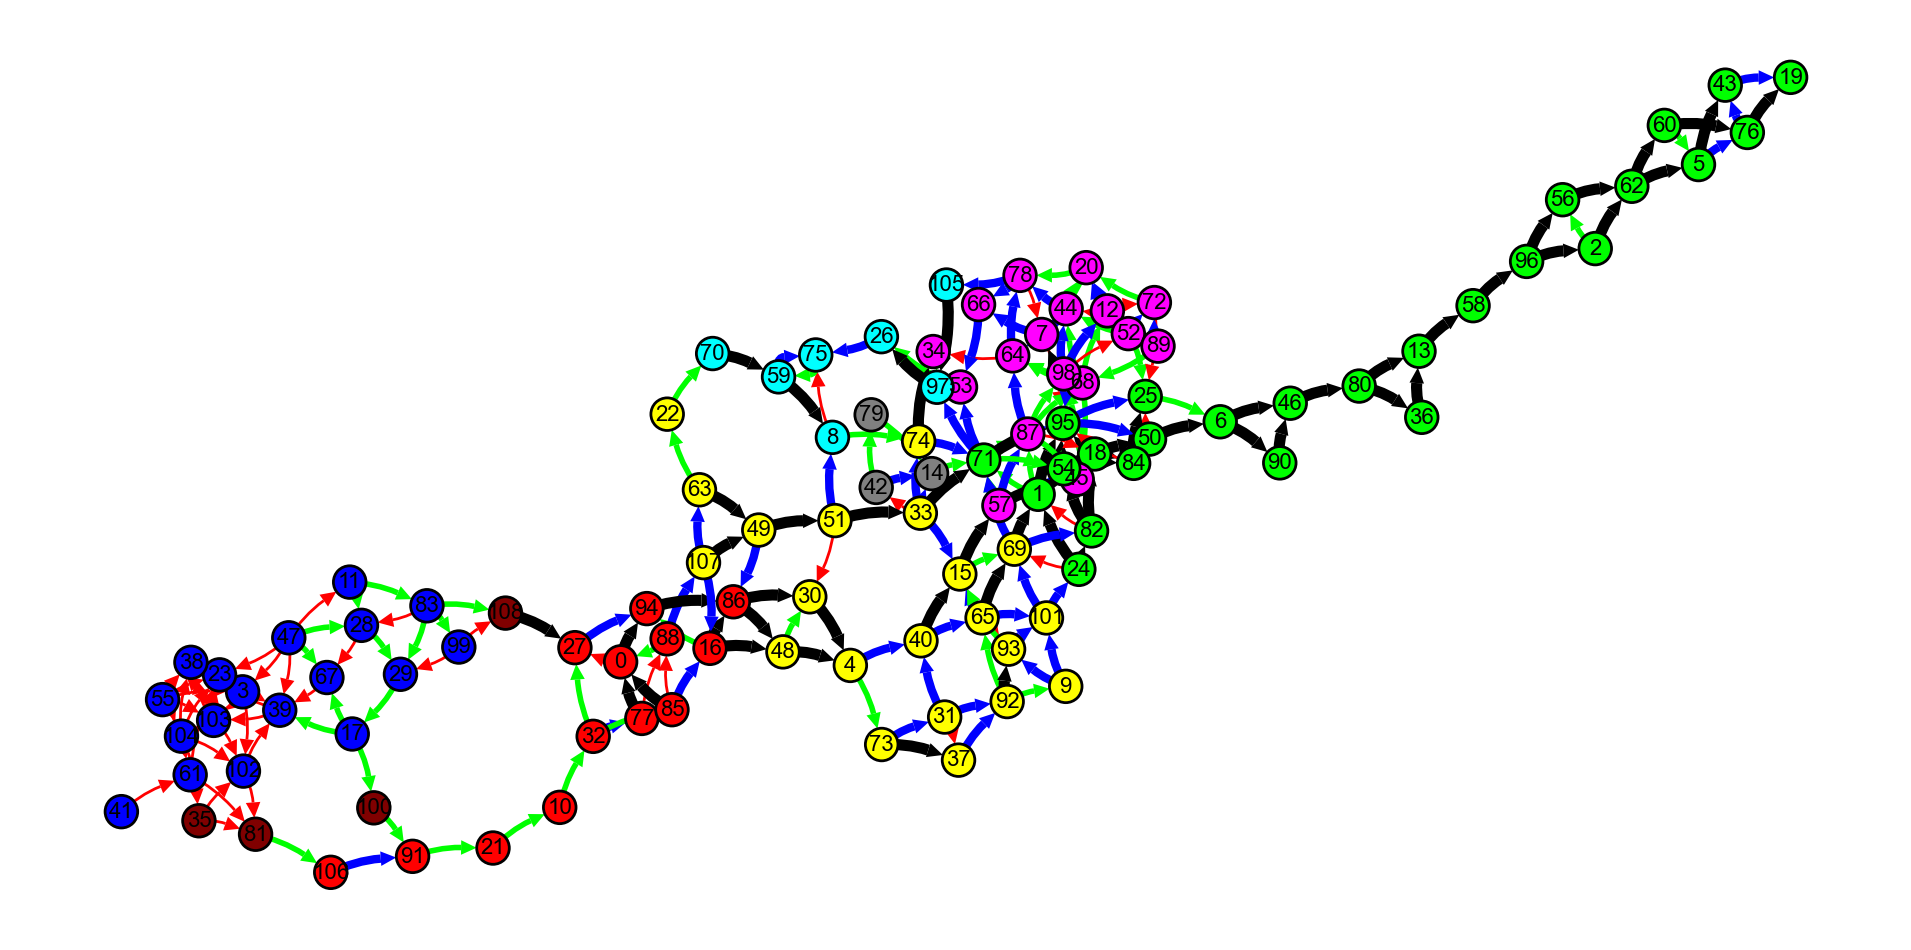

In [ ]:
velog_r = igraph.Graph.Weighted_Adjacency(knot_velocity_graph1.tolist(),  mode='directed') 

from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

id_gen = igraph.UniqueIdGenerator()
vcolor_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
vcolors = [palette[index] for index in vcolor_indices]
velog_r.vs["color"] = vcolors 

velog_r.vs["label"] = [i for i in range(len(knots))]

bins = np.quantile(np.array(velog_r.es["weight"]), [0, 0.33, 0.67 ,1])
bins[0] = bins[0] -1
bins[-1] = bins[-1] +1
edgeWeightCat = pd.cut(pd.Series(velog_r.es["weight"]), bins)
edgeWeightCatcode = edgeWeightCat.cat.codes

palette = list(igraph.ClusterColoringPalette(len(np.unique(edgeWeightCatcode))))
palette[3] = (0.0, 0.0, 0.0, 1.0)
edgecolors = [palette[index] for index in edgeWeightCatcode]
velog_r.es["color"] = edgecolors 

velog_r.es['width'] = edgeWeightCatcode + 1


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_r, layout=layout0, target=ax, autocurve = True,edge_curved="0.1",vertex_size = 0.2, vertex_label_size = 8)

# Laplacian Eigenmap/Diffusion map projection

In [ ]:
import pickle
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

adata2000 = scv.read('data/pancreasd2000.h5ad')

X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]

subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]

In [ ]:
# Laplacian eigenmap embedding

from sklearn.manifold import SpectralEmbedding
LEembedding = SpectralEmbedding(n_components=100)
X_LE = LEembedding.fit_transform(X)
X_LE.shape

(3696, 100)

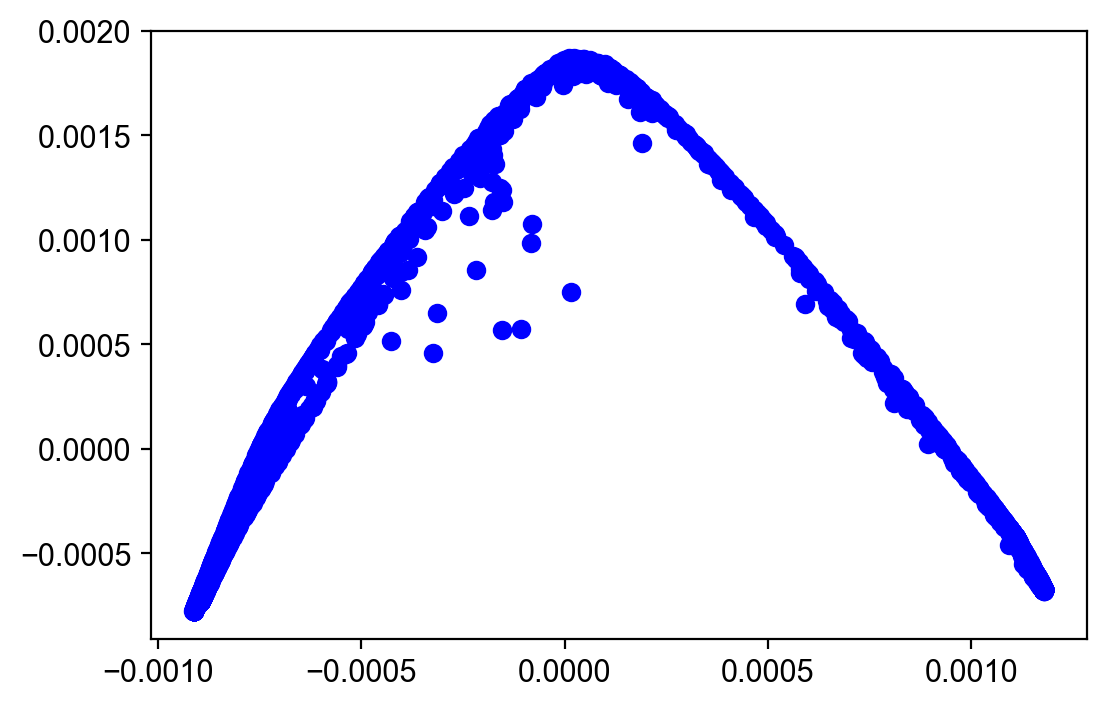

In [ ]:
plt.scatter(X_LE[:,0], X_LE[:,1], c ="blue")
 
# To show the plot
plt.show()

In [ ]:
# # Diffusion map embedding. Not working properly for now
# from pydiffmap import diffusion_map as dm
# DMembedding = dm.DiffusionMap.from_sklearn(n_evecs = 10, alpha = 0.5, epsilon = 'bgh', k=200)
# X_DM = DMembedding.fit_transform(X)

KeyboardInterrupt: 

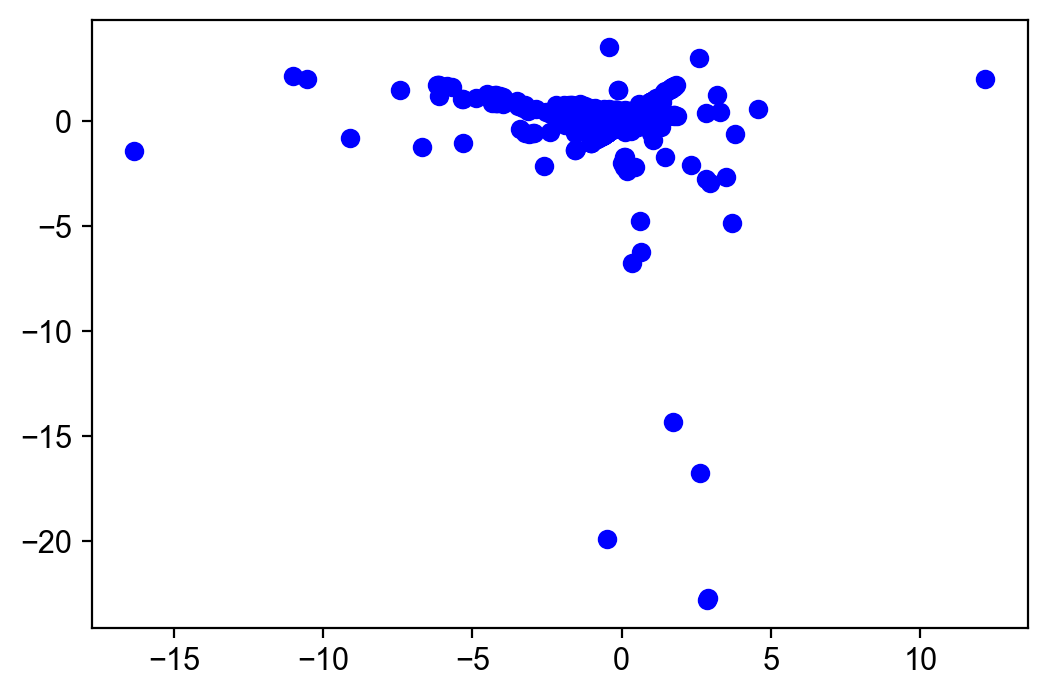

In [ ]:
plt.scatter(X_DM[:,99], X_DM[:,98], c ="blue")
 
# To show the plot
plt.show()

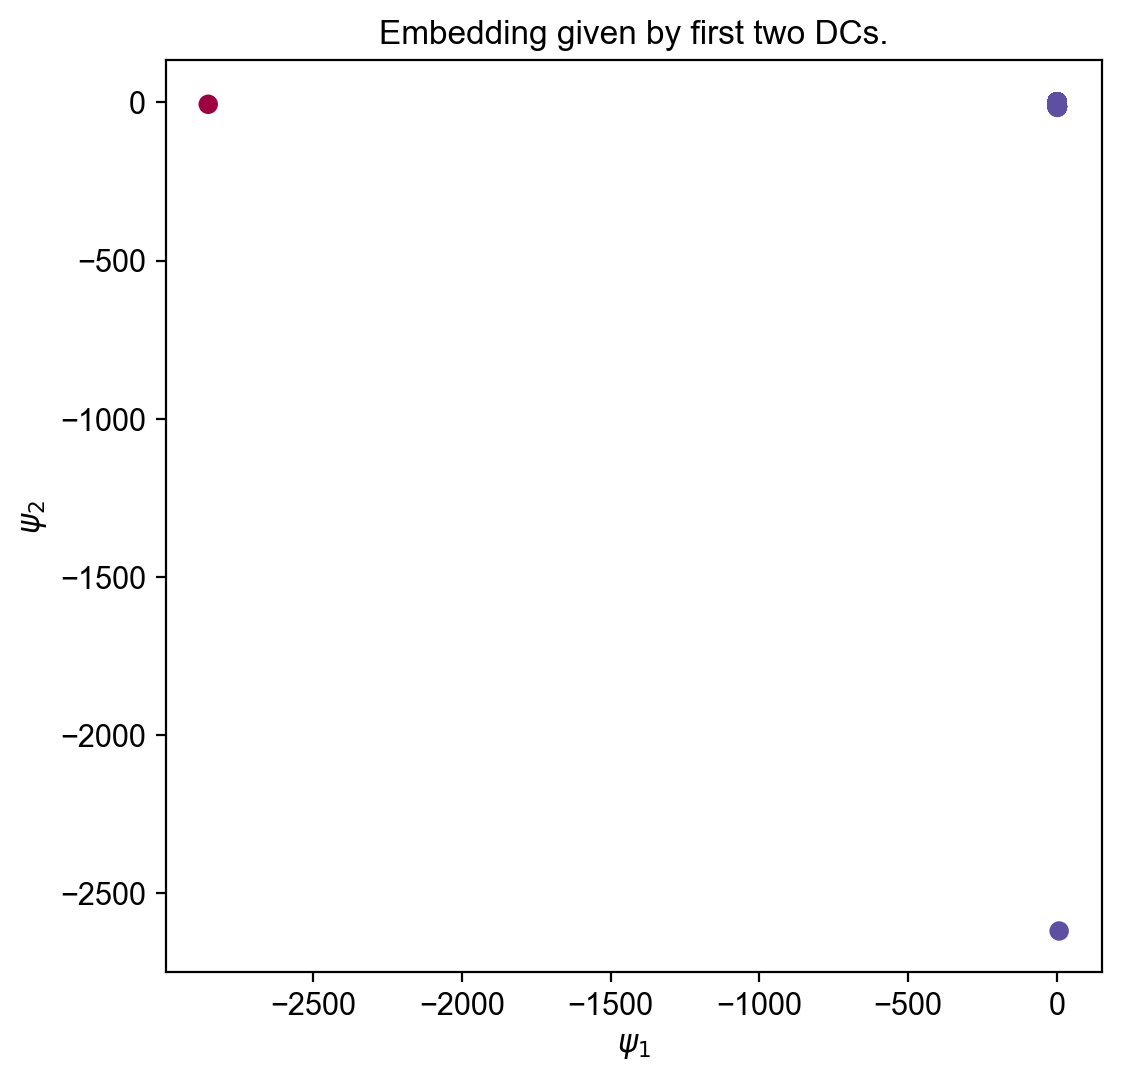

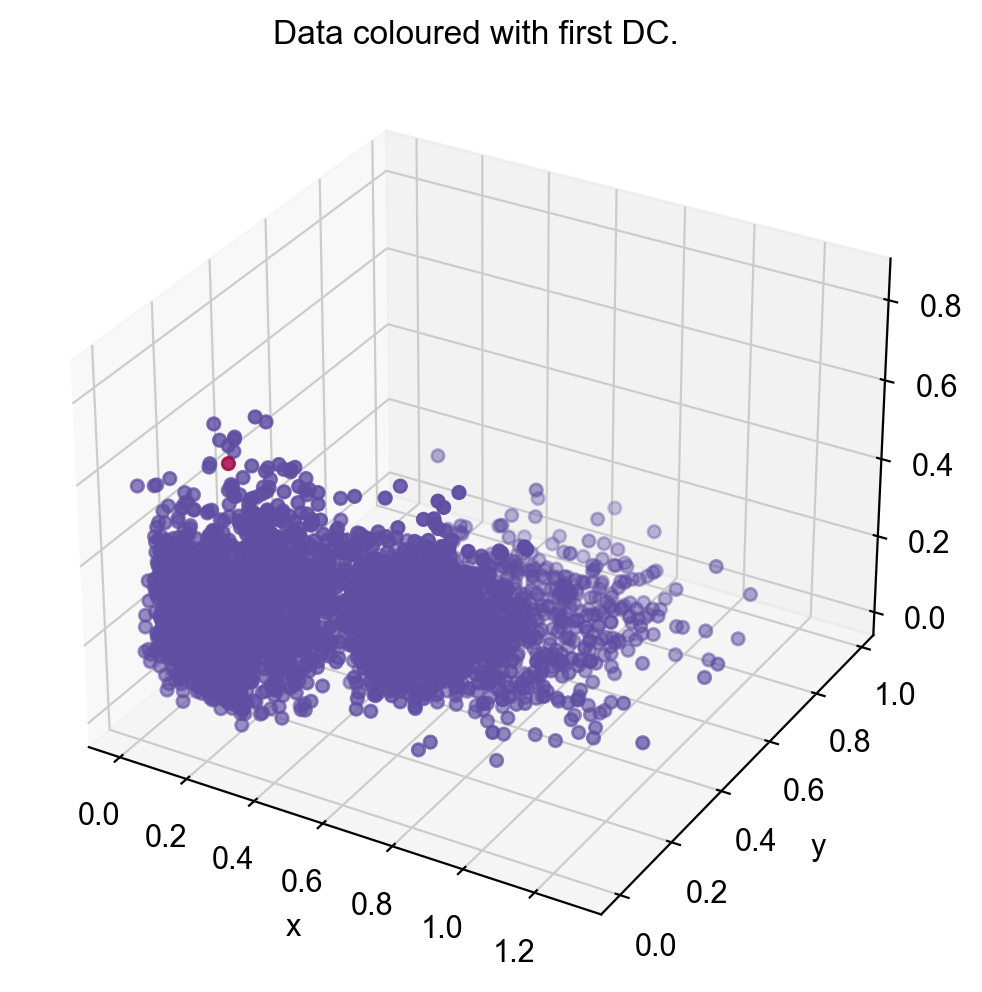

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(DMembedding, scatter_kwargs = {'c': X_DM[:,0], 'cmap': 'Spectral'})
data_plot(DMembedding, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()